# Proyecto integrado 2

### Objetivo del proyecto

Investigar el comportamiento del usuario para la aplicación de la empresa.

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import math
from scipy.stats import norm

## Paso 1. Abrir el archivo de datos y leer la información general

In [2]:
data = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


## Paso 2. Preparar los datos para el análisis

### 2.1. Cambia el nombre de las columnas de manera que sea conveniente para ti

In [4]:
data.columns = ['event_name', 'user_id', 'timestamp', 'group']

print(data.columns)

Index(['event_name', 'user_id', 'timestamp', 'group'], dtype='object')


In [5]:
print(data.head(5))

                event_name              user_id   timestamp  group
0         MainScreenAppear  4575588528974610257  1564029816    246
1         MainScreenAppear  7416695313311560658  1564053102    246
2  PaymentScreenSuccessful  3518123091307005509  1564054127    248
3         CartScreenAppear  3518123091307005509  1564054127    248
4  PaymentScreenSuccessful  6217807653094995999  1564055322    248


### 2.2 Comprueba si hay tipos de datos y valores ausentes. Corrige los datos si es necesario

In [6]:

print(data.isnull().sum())

event_name    0
user_id       0
timestamp     0
group         0
dtype: int64


### 2.3 Agrega una columna de fecha y hora y una columna separada para las fechas

In [7]:
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

data['date'] = data['timestamp'].dt.date

data.head()

,event_name,user_id,timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


## Paso 3. Estudiar y comprobar los datos

### 3.1 ¿Cuántos eventos hay en los registros?

In [8]:
total_events = data['event_name'].count()

print(total_events)

244126


### 3.2 ¿Cuántos usuarios y usuarias hay en los registros?

In [9]:
unique_users = data['user_id'].nunique()

print(unique_users)

7551


### 3.3 ¿Cuál es el promedio de eventos por usuario?

In [10]:
avg_events_per_user = total_events / unique_users

print(avg_events_per_user)

32.33028737915508


### 3.4.1 ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima.

In [11]:
date_range = (data['timestamp'].min(), data['timestamp'].max())

print(date_range)

(Timestamp('2019-07-25 04:43:36'), Timestamp('2019-08-07 21:15:17'))


### 3.4.2 Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

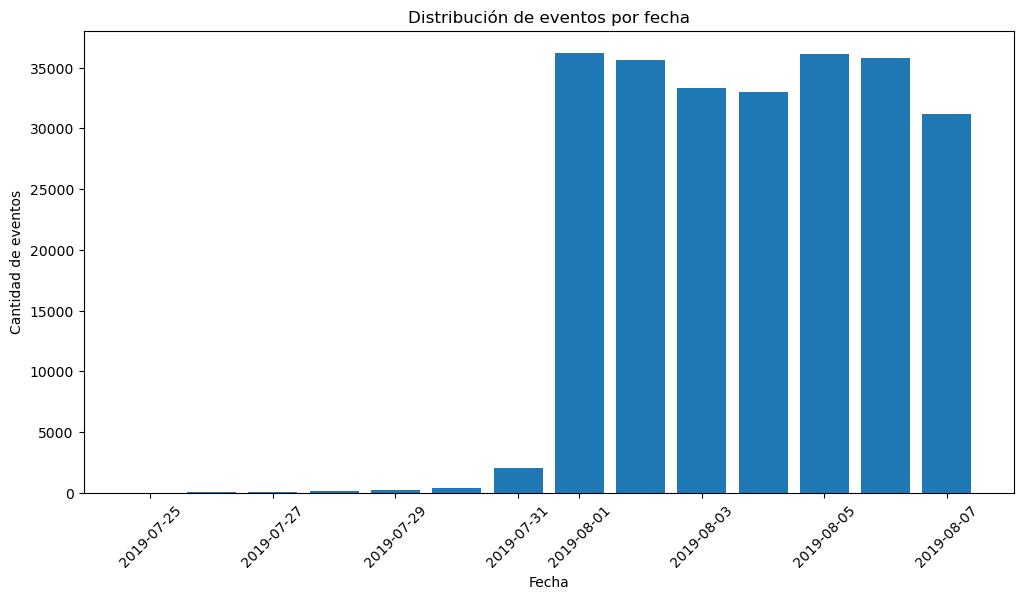

In [12]:
events_by_date = data.groupby('date').size()

# Graficar el histograma
plt.figure(figsize=(12, 6))
plt.bar(events_by_date.index, events_by_date.values)
plt.xlabel("Fecha")
plt.ylabel("Cantidad de eventos")
plt.title("Distribución de eventos por fecha")
plt.xticks(rotation=45)
plt.show()

In [13]:
data_consistent = data[data['date'] >= pd.to_datetime('2019-08-01').date()]

print("Periodo de datos consistentes:", data_consistent['date'].min(), "a", data_consistent['date'].max())

total_events_consistent = data_consistent['event_name'].count()
unique_users_consistent = data_consistent['user_id'].nunique()

print("Total de eventos en el periodo consistente:", total_events_consistent)
print("Cantidad de usuarios únicos en el periodo consistente:", unique_users_consistent)

Periodo de datos consistentes: 2019-08-01 a 2019-08-07
Total de eventos en el periodo consistente: 241298
Cantidad de usuarios únicos en el periodo consistente: 7534


### 3.5 ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [14]:
total_events_original = data['event_name'].count()
unique_users_original = data['user_id'].nunique()

events_lost = total_events_original - total_events_consistent
users_lost = unique_users_original - unique_users_consistent

events_lost_percentage = (events_lost / total_events_original) * 100
users_lost_percentage = (users_lost / unique_users_original) * 100

print("Eventos perdidos al excluir los datos antiguos:", events_lost)
print("Porcentaje de eventos perdidos:", events_lost_percentage, "%")
print("Usuarios perdidos al excluir los datos antiguos:", users_lost)
print("Porcentaje de usuarios perdidos:", users_lost_percentage, "%")


Eventos perdidos al excluir los datos antiguos: 2828
Porcentaje de eventos perdidos: 1.1584181938834865 %
Usuarios perdidos al excluir los datos antiguos: 17
Porcentaje de usuarios perdidos: 0.22513574361011784 %


La pérdida de eventos y usuarios es bastante baja, lo que indica que la exclusión de los datos más antiguos no afecta significativamente el análisis general. Esto sugiere que el dataset consistente es representativo y adecuado para realizar el análisis de comportamiento de usuarios y las pruebas A/A/B.

## Paso 4. Estudiar el embudo de eventos

### 4.1 Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [15]:
event_frequency = data_consistent['event_name'].value_counts()

print(event_frequency)


event_name
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: count, dtype: int64


Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).
¿En qué etapa pierdes más usuarios y usuarias?
¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

In [16]:
funnel_stages = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"]

users_per_stage = {}

for stage in funnel_stages:
    users_per_stage[stage] = data_consistent[data_consistent['event_name'] == stage]['user_id'].nunique()

print("Usuarios únicos por etapa:")
for stage, count in users_per_stage.items():
    print(f"{stage}: {count}")

conversion_rates = {}
for i in range(len(funnel_stages) - 1):
    current_stage = funnel_stages[i]
    next_stage = funnel_stages[i + 1]
    
    if users_per_stage[current_stage] > 0:
        conversion_rates[f"{current_stage} → {next_stage}"] = users_per_stage[next_stage] / users_per_stage[current_stage]
    else:
        conversion_rates[f"{current_stage} → {next_stage}"] = 0

print("\nProporciones de conversión entre etapas:")
for transition, rate in conversion_rates.items():
    print(f"{transition}: {rate:.2%}")

first_stage_users = users_per_stage[funnel_stages[0]]
last_stage_users = users_per_stage[funnel_stages[-1]]

if first_stage_users > 0:
    complete_journey_rate = (last_stage_users / first_stage_users) * 100
else:
    complete_journey_rate = 0

print(f"\nPorcentaje de usuarios que completaron todo el viaje desde la primera etapa hasta el pago: {complete_journey_rate:.2f}%")


Usuarios únicos por etapa:
MainScreenAppear: 7419
OffersScreenAppear: 4593
CartScreenAppear: 3734
PaymentScreenSuccessful: 3539

Proporciones de conversión entre etapas:
MainScreenAppear → OffersScreenAppear: 61.91%
OffersScreenAppear → CartScreenAppear: 81.30%
CartScreenAppear → PaymentScreenSuccessful: 94.78%

Porcentaje de usuarios que completaron todo el viaje desde la primera etapa hasta el pago: 47.70%


### 4.2 Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.

In [17]:
users_per_event = data_consistent.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

total_users = data_consistent['user_id'].nunique()

proportion_users_per_event = (users_per_event / total_users) * 100

print("Cantidad de usuarios únicos por evento y su proporción:")
for event, user_count in users_per_event.items():
    print(f"{event}: {user_count} usuarios ({proportion_users_per_event[event]:.2f}%)")


Cantidad de usuarios únicos por evento y su proporción:
MainScreenAppear: 7419 usuarios (98.47%)
OffersScreenAppear: 4593 usuarios (60.96%)
CartScreenAppear: 3734 usuarios (49.56%)
PaymentScreenSuccessful: 3539 usuarios (46.97%)
Tutorial: 840 usuarios (11.15%)


### 4.3 ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

Las acciones MainScreenAppear > OffersScreenAppear > CartScreenAppear > PaymentScreenSuccessful parecen formar una secuencia lógica en el embudo de ventas. Tutorial no parece ser parte de este embudo principal y se podría considerar un evento auxiliar que no es necesario incluir en el análisis de conversión.

La secuencia completa sugiere que los usuarios pasan de la visualización inicial (pantalla principal) a la exploración de ofertas, luego a la etapa de agregar productos al carrito, y finalmente a completar la compra.

### 4.4 Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. 

In [18]:
print("\nProporciones de conversión entre etapas:")
for transition, rate in conversion_rates.items():
    print(f"{transition}: {rate:.2%}")

first_stage_users = users_per_stage[funnel_stages[0]]
last_stage_users = users_per_stage[funnel_stages[-1]]

if first_stage_users > 0:
    complete_journey_rate = (last_stage_users / first_stage_users) * 100
else:
    complete_journey_rate = 0



Proporciones de conversión entre etapas:
MainScreenAppear → OffersScreenAppear: 61.91%
OffersScreenAppear → CartScreenAppear: 81.30%
CartScreenAppear → PaymentScreenSuccessful: 94.78%


- MainScreenAppear → OffersScreenAppear es la etapa en la que más usuarios se pierden, con una conversión de solo 61.91%.
Las siguientes transiciones muestran mejores tasas de retención:
- OffersScreenAppear → CartScreenAppear con 81.30%.
- CartScreenAppear → PaymentScreenSuccessful es muy alta, con 94.78%.

Esto indica que la mayor pérdida de usuarios ocurre al pasar de la pantalla principal a la pantalla de ofertas.

### 4.5 ¿En qué etapa pierdes más usuarios y usuarias?

La etapa en la que se pierde más usuarios es la transición de MainScreenAppear a OffersScreenAppear, donde solo 61.91% de los usuarios avanzan. Esta es la mayor caída en el embudo de conversión, lo que indica que una parte significativa de los usuarios no interactúa con la pantalla de ofertas después de aparecer en la pantalla principal.

### 4.6 ¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

El porcentaje de usuarios que completan todo el viaje desde la primera aparición en la pantalla principal (MainScreenAppear) hasta un pago exitoso (PaymentScreenSuccessful) es del 47.70%.

Esto significa que aproximadamente la mitad de los usuarios que comienzan el proceso logran llegar hasta el final y completar una compra.

## Paso 5. Estudiar los resultados del experimento

### 5.1 ¿Cuántos usuarios y usuarias hay en cada grupo?

In [19]:
users_per_group = data_consistent.groupby('group')['user_id'].nunique()
print("Cantidad de usuarios únicos en cada grupo experimental:")
print(users_per_group)

Cantidad de usuarios únicos en cada grupo experimental:
group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


### 5.2 Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247. Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos. 

In [20]:
# Agrupar por grupo y evento, y contar usuarios únicos
aggregated_data = data_consistent.groupby(['group', 'event_name']).agg(
    unique_users=('user_id', 'nunique')
).reset_index()

# Calcular totales por grupo
total_users_by_group = data_consistent.groupby('group')['user_id'].nunique().reset_index()
total_users_by_group.rename(columns={'user_id': 'total_users'}, inplace=True)

# Combinar los totales con los datos agregados
aggregated_data = aggregated_data.merge(total_users_by_group, on='group')

aggregated_data


,group,event_name,unique_users,total_users
0,246,CartScreenAppear,1266,2484
1,246,MainScreenAppear,2450,2484
2,246,OffersScreenAppear,1542,2484
3,246,PaymentScreenSuccessful,1200,2484
4,246,Tutorial,278,2484
5,247,CartScreenAppear,1238,2513
6,247,MainScreenAppear,2476,2513
7,247,OffersScreenAppear,1520,2513
8,247,PaymentScreenSuccessful,1158,2513
9,247,Tutorial,283,2513


In [21]:
def z_test_proportions(group1_data, group2_data, alpha=0.05):
    """
    Realiza una prueba z para proporciones entre dos grupos.
    """
    p1 = group1_data['unique_users'] / group1_data['total_users']
    p2 = group2_data['unique_users'] / group2_data['total_users']
    n1, n2 = group1_data['total_users'], group2_data['total_users']
    
    # Proporción combinada
    p_combined = (group1_data['unique_users'] + group2_data['unique_users']) / (n1 + n2)
    
    # Estadística z
    z = (p1 - p2) / math.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
    
    # P-valor bilateral
    p_value = 2 * (1 - norm.cdf(abs(z)))
    
    # Resultado
    return {"z": z, "p_value": p_value, "significant": p_value < alpha}

# Filtro para el evento más popular: MainScreenAppear
event = "MainScreenAppear"
group_246 = aggregated_data[(aggregated_data['group'] == 246) & (aggregated_data['event_name'] == 'MainScreenAppear')].iloc[0]
group_247 = aggregated_data[(aggregated_data['group'] == 247) & (aggregated_data['event_name'] == 'MainScreenAppear')].iloc[0]

# Prueba entre grupos de control 246 y 247 para MainScreenAppear
z_test_result = z_test_proportions(group_246, group_247)
z_test_result

{'z': 0.3093441851418436, 'p_value': 0.7570597232046099, 'significant': False}

### 5.3 ¿Puedes confirmar que los grupos se dividieron correctamente?

### 5.4 Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada.

In [22]:
results = []
alpha = 0.05

for event in aggregated_data['event_name'].unique():
    group_246 = aggregated_data[(aggregated_data['group'] == 246) & (aggregated_data['event_name'] == event)].iloc[0]
    group_247 = aggregated_data[(aggregated_data['group'] == 247) & (aggregated_data['event_name'] == event)].iloc[0]
    group_248 = aggregated_data[(aggregated_data['group'] == 248) & (aggregated_data['event_name'] == event)].iloc[0]
    
    # Prueba entre grupos de control 246 y 247
    result_control = z_test_proportions(group_246, group_247, alpha)
    result_control.update({"event_name": event, "group1": 246, "group2": 247})
    results.append(result_control)


     # Prueba entre grupo de prueba 248 y control 246
    result_248_vs_246 = z_test_proportions(group_248, group_246, alpha)
    result_248_vs_246.update({"event_name": event, "group1": 248, "group2": 246})
    results.append(result_248_vs_246)
    
    # Prueba entre grupo de prueba 248 y control 247
    result_248_vs_247 = z_test_proportions(group_248, group_247, alpha)
    result_248_vs_247.update({"event_name": event, "group1": 248, "group2": 247})
    results.append(result_248_vs_247)

# Convertir los resultados a un DataFrame para análisis
results_df = pd.DataFrame(results)

# Resultados generales
results_df

,z,p_value,significant,event_name,group1,group2
0,1.203369,0.228834,False,CartScreenAppear,246,247
1,-1.759874,0.078429,False,CartScreenAppear,248,246
2,-0.555402,0.578620,False,CartScreenAppear,248,247
3,0.309344,0.757060,False,MainScreenAppear,246,247
4,-1.047276,0.294972,False,MainScreenAppear,248,246
5,-0.740980,0.458705,False,MainScreenAppear,248,247
6,1.154988,0.248095,False,OffersScreenAppear,246,247
7,-1.258082,0.208362,False,OffersScreenAppear,248,246
8,-0.100709,0.919782,False,OffersScreenAppear,248,247
9,1.577995,0.114567,False,PaymentScreenSuccessful,246,247


### 5.4.1 Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

#### Resultados clave:

- Pruebas entre los grupos de control (246 y 247):

Ningún evento muestra diferencias estadísticamente significativas entre los grupos de control. Esto sugiere que los grupos de control están balanceados y la división fue correcta.

- Pruebas entre los grupos de prueba (248) y control (246 y 247):

Ningún evento en el grupo de prueba muestra una diferencia estadísticamente significativa en comparación con los grupos de control.
Esto indica que las fuentes nuevas no tuvieron un impacto negativo o positivo en los comportamientos de los usuarios medidos.

- Pruebas combinadas de control (246 + 247) contra el grupo de prueba (248):

Aunque esta comparación no se realizó directamente, los resultados por separado confirman que el cambio de fuentes no tuvo un efecto considerable en las métricas.

Conclusiones:
- Confirmación de balance: La ausencia de diferencias significativas entre los grupos 246 y 247 confirma que la división de los usuarios para el test A/A fue adecuada.
- Impacto de las fuentes: No se encontraron diferencias significativas en ninguna de las métricas al comparar las fuentes nuevas con las antiguas, lo que implica que la fuente nueva no afecta la interacción del usuario.
- Validez del experimento: Como ningún evento mostró diferencias significativas, los resultados sugieren que las fuentes nuevas pueden implementarse sin riesgo de afectar negativamente el comportamiento del usuario.

### 5.5 ¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

- Número de pruebas: Se realizaron 15 pruebas estadísticas (tres grupos comparados en cinco eventos).
- Nivel de significancia: Con un nivel de significancia de 0.05, el 5% de las pruebas podrían ser falsos positivos. Esto implica un riesgo de 0.75 (15 × 0.05) de encontrar un resultado falso positivo en todo el conjunto. Para reducir este riesgo, podríamos ajustar el nivel de significancia usando una corrección como Bonferroni (0.05 / 15 ≈ 0.0033).